<a href="https://colab.research.google.com/github/MayerT1/PIPECAST/blob/main/Step1_HRRR_AOI_Delineation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jul-08 16:00 UTC F06 ┊ GRIB2 @ local ┊ IDX @ aws


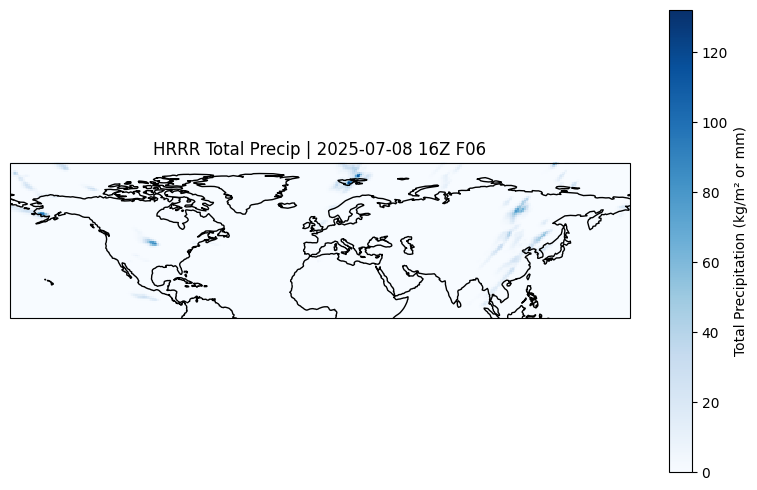

In [1]:
# ✅ Block 1: Install necessary packages
!pip install herbie --quiet
!pip install cfgrib xarray netcdf4 cartopy --quiet

# ✅ Block 2: Import and configure
from herbie import Herbie
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Choose a date, time, and forecast hour
from datetime import datetime
date = "2025-07-08 16:00"
fxx = 6  # Forecast hour (adjust as needed)

# ✅ Block 3: Load HRRR forecast
H = Herbie(
    date,
    model="hrrr",
    product="sfc",
    fxx=fxx,
    save_dir="/root/data",
    verbose=True,
)

# ✅ Block 4: Load dataset using known variable name
# Download and open as xarray Dataset
ds = H.xarray("APCP:surface")  # Will automatically fallback to entire file if needed

# ✅ OR directly open from downloaded GRIB2 file (if index fails)
# H.download()
# ds = xr.open_dataset(H.local_grib, engine="cfgrib")

# ✅ Block 5: Access and plot precipitation field
precip = ds["tp"]  # Total Precipitation

plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

precip.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="Blues",
    cbar_kwargs={"label": "Total Precipitation (kg/m² or mm)"}
)

ax.coastlines()
ax.set_title(f"HRRR Total Precip | {H.date:%Y-%m-%d %HZ} F{H.fxx:02d}")
plt.show()


AOI creaiton by a threshold

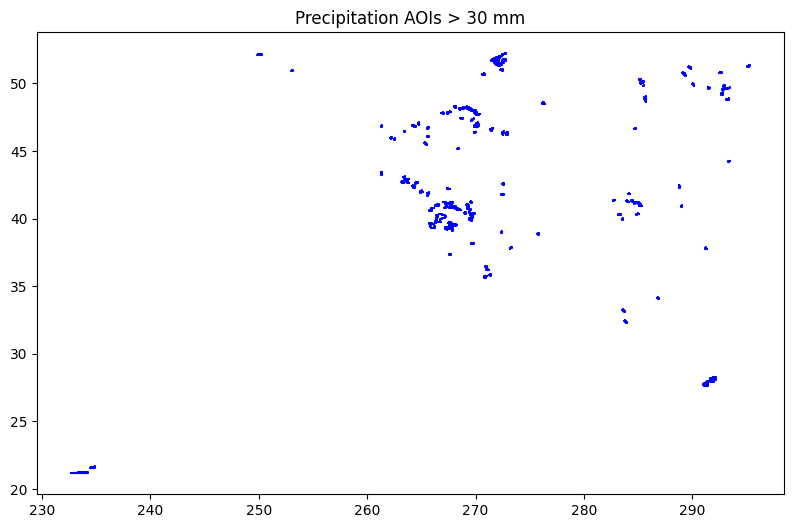

In [2]:
# Block 1: Install necessary geospatial tools
!pip install geopandas shapely rasterio scipy pyproj --quiet

# Block 2: Import libraries
import numpy as np
import geopandas as gpd
from shapely.geometry import shape, Polygon, mapping
import matplotlib.pyplot as plt
from scipy.ndimage import label
import rasterio.features
import xarray as xr

# Block 3: Define threshold and extract data
threshold_mm = 30  # e.g., 10 mm total precipitation
precip = ds["tp"]  # Already loaded from Herbie (xarray dataset)
precip_data = precip.values

# Create binary mask and label connected regions
mask = precip_data > threshold_mm
labeled, num_features = label(mask)

# Get affine transform for geolocation
transform = rasterio.transform.from_bounds(
    float(ds.longitude.min()), float(ds.latitude.min()),
    float(ds.longitude.max()), float(ds.latitude.max()),
    ds.dims["x"], ds.dims["y"]
)

# Convert labeled mask to polygons
shapes = rasterio.features.shapes(
    labeled.astype(np.int16),
    mask=mask,
    transform=transform
)

# Create GeoDataFrame with metadata
polygons = []
ids = []
means = []
times = []

for geom, label_id in shapes:
    if label_id == 0:
        continue
    poly = shape(geom)
    if poly.area > 0.01:  # Optional area filter
        # Get mask for this AOI
        aoi_mask = labeled == label_id
        mean_precip = float(precip_data[aoi_mask].mean())

        polygons.append(poly)
        ids.append(int(label_id))
        means.append(mean_precip)
        times.append(str(ds.valid_time.values))  # use forecast valid time

# Build GeoDataFrame with attributes
gdf = gpd.GeoDataFrame({
    'id': ids,
    'mean_precip_mm': means,
    'forecast_time': times
}, geometry=polygons, crs="EPSG:4326")

# Save to GeoJSON if needed
gdf.to_file("precip_aois.geojson", driver="GeoJSON")

# Block 4: Plot
gdf.boundary.plot(edgecolor='blue', figsize=(10, 6))
plt.title(f"Precipitation AOIs > {threshold_mm} mm")
plt.show()


In [3]:
gdf

,id,mean_precip_mm,forecast_time,geometry
0,4,57.880348,2025-07-08T22:00:00.000000000,"POLYGON ((249.86339 52.19952, 249.86339 52.169..."
1,3,52.174999,2025-07-08T22:00:00.000000000,"POLYGON ((272.60195 52.22924, 272.60195 52.199..."
2,11,44.220409,2025-07-08T22:00:00.000000000,"POLYGON ((272.64263 51.84283, 272.64263 51.813..."
3,9,49.749672,2025-07-08T22:00:00.000000000,"POLYGON ((272.07314 52.02118, 272.07314 51.961..."
4,15,45.934074,2025-07-08T22:00:00.000000000,"POLYGON ((272.19518 51.48615, 272.19518 51.456..."
...,...,...,...,...
104,422,48.195999,2025-07-08T22:00:00.000000000,"POLYGON ((291.80159 28.27184, 291.80159 28.242..."
105,423,42.447533,2025-07-08T22:00:00.000000000,"POLYGON ((291.39482 28.00433, 291.39482 27.974..."
106,434,33.962219,2025-07-08T22:00:00.000000000,"POLYGON ((234.77215 21.67315, 234.77215 21.643..."
107,435,35.078182,2025-07-08T22:00:00.000000000,"POLYGON ((234.44673 21.64343, 234.44673 21.613..."


In [4]:
# Install folium if needed
!pip install folium --quiet

import folium
from folium import GeoJson
from folium.plugins import Fullscreen

# Center the map roughly on the continental US
center_lat = float(ds.latitude.mean())
center_lon = float(ds.longitude.mean())

# Create the base map
m = folium.Map(location=[center_lat, center_lon], zoom_start=5, tiles="CartoDB positron")

# Add fullscreen button
Fullscreen(position='topright').add_to(m)

# Add AOIs to the map
geojson_layer = folium.GeoJson(
    gdf,
    name="Precipitation AOIs",
    style_function=lambda feature: {
        'fillColor': 'blue',
        'color': 'red',
        'weight': 1,
        'fillOpacity': 0.4,
    },
    tooltip=folium.GeoJsonTooltip(fields=["id"], aliases=["AOI ID"])
)

geojson_layer.add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Display the map
m


Step 2 (NASA Haromny to ASF for ICEYE SAR data)

In [5]:
!pip install earthaccess


In [6]:
import earthaccess

# Login securely and cache your token
auth = earthaccess.login(strategy="interactive")  # or "browser" if needed


Enter your Earthdata Login username: tjm0042
Enter your Earthdata password: ··········


AOI from above


In [ ]:
# # Select the AOI (first one in this example)
# aoi = gdf.geometry.iloc[7]

# # Extract bounds: minx=min_lon, miny=min_lat, maxx=max_lon, maxy=max_lat
# min_lon, min_lat, max_lon, max_lat = aoi.bounds

# # Format as tuple
# bounding_box = (round(min_lon, 4), round(min_lat, 4),
#                 round(max_lon, 4), round(max_lat, 4))

# print("Formatted Bounding Box:", bounding_box)



In [13]:
def normalize_bbox(bbox):
    """Convert longitudes from 0–360 to -180–180 range."""
    min_lon, min_lat, max_lon, max_lat = bbox

    if min_lon > 180:
        min_lon -= 360
    if max_lon > 180:
        max_lon -= 360

    return (min_lon, min_lat, max_lon, max_lat)

# Example: starting with AOI from GeoDataFrame
aoi = gdf.geometry.iloc[0]
bbox = aoi.bounds  # (minx, miny, maxx, maxy)

# Reorder to (min_lon, min_lat, max_lon, max_lat)
bbox_tuple = (bbox[0], bbox[1], bbox[2], bbox[3])

# Normalize
normalized_bbox = normalize_bbox(bbox_tuple)

print("Normalized Bounding Box:", normalized_bbox)


Normalized Bounding Box: (-110.17728477378171, 52.08062446306615, -109.72983554833053, 52.19951976167543)


In [20]:
datasets = earthaccess.search_data(provider="CSDA", temporal=None, bounding_box=normalized_bbox, limit=20)
for d in datasets:
    print(d['short_name'])

ValueError: Unknown key limit

In [14]:
datasets = earthaccess.search_data(
    short_name="ICEYE",  # Try variations like "CSDA_ICEYE" if needed
    temporal=("2024-06-01", "2024-06-10"),
    bounding_box= normalized_bbox #(-120.0, 35.0, -118.0, 37.0),
)


In [18]:
datasets

[]

In [17]:
for granule in datasets:
    print(granule.data_links()[0])  # Show the download URL
    earthaccess.download(granule)   # Download file


NameError: name 'granule' is not defined

In [16]:
token = earthaccess.auth.authenticated_token()
headers = {"Authorization": f"Bearer {token}"}


AttributeError: module 'earthaccess.auth' has no attribute 'authenticated_token'